In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import shap
from lime.lime_tabular import LimeTabularExplainer
from anchor import anchor_tabular

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filepath = 'healthcare-dataset-stroke-data.csv'
data = pd.read_csv(filepath)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<font color="bluegrey" size=+1.0><b>Data Preprocessing</b></font>

In [3]:
X, y = preprocess_data(filepath, encoding_strategy="label", scale=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check if SMOTE worked by displaying the class distribution after resampling
print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_res.value_counts()}")

Before SMOTE: stroke
0    3901
1     187
Name: count, dtype: int64
After SMOTE: stroke
0    3901
1    3901
Name: count, dtype: int64


<font color="bluegrey" size=+1.0><b>Decision Tree</b></font>

Decision Tree Metrics
Accuracy: 0.90
ROC AUC: 0.56
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.17      0.16      0.17        62

    accuracy                           0.90      1022
   macro avg       0.56      0.56      0.56      1022
weighted avg       0.90      0.90      0.90      1022

age                          0.436605
avg_glucose_level            0.133278
bmi                          0.083606
residence_stroke_risk        0.067829
work_type                    0.042032
gender                       0.040393
Residence_type               0.037855
gender_stroke_risk           0.023156
smoking_status               0.021097
ever_married                 0.020603
bmi_stroke_risk              0.020511
stroke_risk_score            0.016615
work_type_stroke_risk        0.014626
hypertension_stroke_risk     0.008587
age_stroke_risk              0.007133
heart_disease                0.004501
smoking_stroke

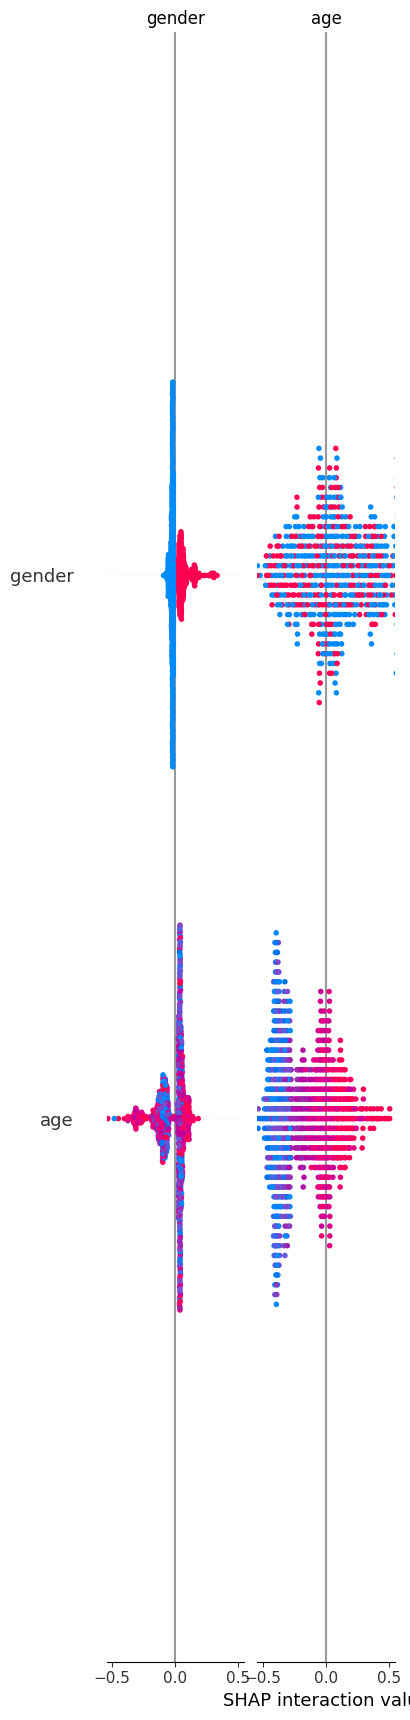

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healt


Instance 1 - Anchor Explanation:
Anchor condition(s): ['age <= 41.58']
Precision: 0.96, Coverage: 0.25


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healt


Instance 2 - Anchor Explanation:
Anchor condition(s): ['age <= 41.58']
Precision: 0.97, Coverage: 0.24


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healt


Instance 3 - Anchor Explanation:
Anchor condition(s): ['age <= 41.58']
Precision: 0.98, Coverage: 0.25


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healt


Instance 4 - Anchor Explanation:
Anchor condition(s): ['residence_stroke_risk > 0.00', 'bmi <= 25.50', 'work_type > 2.00']
Precision: 0.96, Coverage: 0.04


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healt


Instance 5 - Anchor Explanation:
Anchor condition(s): ['residence_stroke_risk > 0.00', 'gender_stroke_risk > 0.00', 'stroke_risk_score <= 4.00', 'smoking_status > 1.00', '78.97 < avg_glucose_level <= 146.27']
Precision: 0.95, Coverage: 0.02


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [5]:
X, y = preprocess_data(filepath, encoding_strategy="label", scale=False)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_res, y_train_res)
y_pred = dt_model.predict(X_test)

print("Decision Tree Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

feature_importance = pd.Series(dt_model.feature_importances_, index=X_test.columns)
print(feature_importance.sort_values(ascending=False))

# SHAP for Decision Tree
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20, show=True)

feature_names = X.columns.tolist()

anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=['No Stroke', 'Stroke'],
    feature_names=feature_names,
    train_data=X_train_res.values
)

# Select an instance from the test set for explanation (can choose any instance here, we select the first one)
instance = X_test.iloc[0:1]  # Keep the data in DataFrame format
y_pred = dt_model.predict(instance)

for i in range(5):  # Show explanation for first 5 test instances
    instance = X_test.iloc[i:i+1]  # Keep the data in DataFrame format
    anchor_exp = anchor_explainer.explain_instance(instance.values[0], dt_model.predict)
    print(f"\nInstance {i+1} - Anchor Explanation:")
    print(f"Anchor condition(s): {anchor_exp.names()}")
    print(f"Precision: {anchor_exp.precision():.2f}, Coverage: {anchor_exp.coverage():.2f}")
    print("="*50)

<font color="bluegrey" size=+1.0><b>Logistic Regression</b></font>

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\zen\Documents\-- four\

Logistic Regression Metrics
Accuracy: 0.89
ROC AUC: 0.54
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       960
           1       0.13      0.13      0.13        62

    accuracy                           0.89      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.89      0.89      0.89      1022



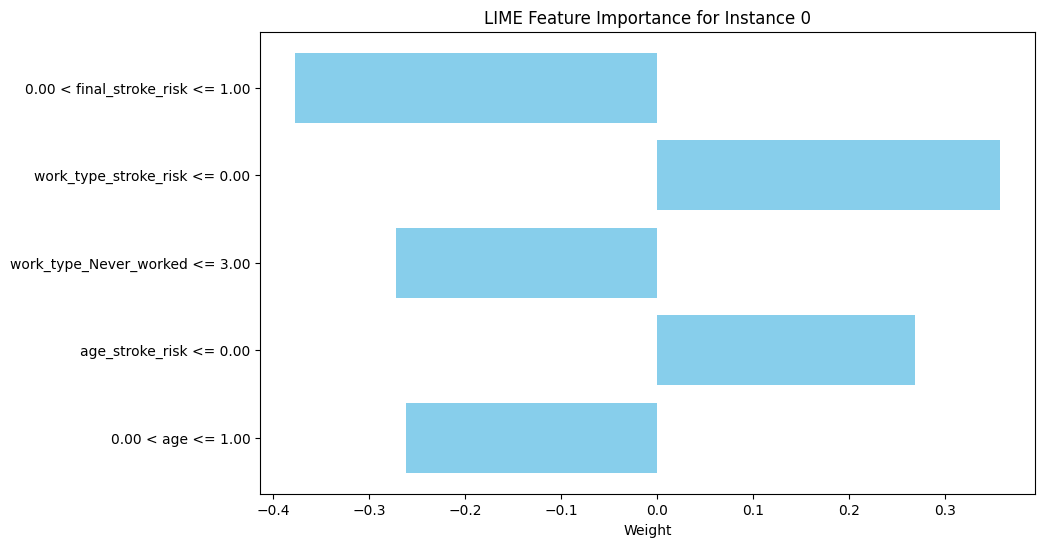

In [6]:
# Preprocess the data with One-Hot Encoding
X, y = preprocess_data(filepath, encoding_strategy="onehot", scale=True)

lr_model = LogisticRegression()
lr_model.fit(X_train_res, y_train_res)
y_pred = lr_model.predict(X_test)

print("Logistic Regression Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

explainer = LimeTabularExplainer(
    training_data=X_train_res.values,
    mode='classification',
    feature_names=X.columns,
    class_names=['No Stroke', 'Stroke'],
    discretize_continuous=True
)

# Explain an instance (e.g., the first test sample)
instance_idx = 0  # You can change this to explain different samples
exp = explainer.explain_instance(X_test.iloc[instance_idx], lr_model.predict_proba, num_features=5)

# Show explanation in notebook
exp.show_in_notebook()

# Extract feature importance
lime_explanation = exp.as_list()
lime_df = pd.DataFrame(lime_explanation, columns=['Feature', 'Weight'])

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.barh(lime_df['Feature'], lime_df['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.title(f'LIME Feature Importance for Instance {instance_idx}')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

<font color="bluegrey" size=+1.0><b>Naive-Bayes</b></font>

In [7]:
X, y = preprocess_data(filepath, encoding_strategy="label", scale=False)

nb_model = GaussianNB()
nb_model.fit(X_train_res, y_train_res)  # Train on the resampled data
y_pred = nb_model.predict(X_test)  # Predict on the original test set

# Metrics
print("Naive Bayes Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Anchor for Naive Bayes
feature_names = X.columns.tolist()

anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=['No Stroke', 'Stroke'],
    feature_names=feature_names,
    train_data=X_train_res.values
)

# Select an instance from the test set for explanation (can choose any instance here, we select the first one)
instance = X_test.iloc[0:1]  # Keep the data in DataFrame format
y_pred = nb_model.predict(instance)

for i in range(5):  # Show explanation for first 5 test instances
    instance = X_test.iloc[i:i+1]  # Keep the data in DataFrame format
    anchor_exp = anchor_explainer.explain_instance(instance.values[0], nb_model.predict)
    print(f"\nInstance {i+1} - Anchor Explanation:")
    print(f"Anchor condition(s): {anchor_exp.names()}")
    print(f"Precision: {anchor_exp.precision():.2f}, Coverage: {anchor_exp.coverage():.2f}")
    print("="*50)

Naive Bayes Metrics
Accuracy: 0.65
ROC AUC: 0.71
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       960
           1       0.12      0.77      0.21        62

    accuracy                           0.65      1022
   macro avg       0.55      0.71      0.49      1022
weighted avg       0.93      0.65      0.74      1022



c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\


Instance 1 - Anchor Explanation:
Anchor condition(s): ['age_stroke_risk <= 0.00']
Precision: 1.00, Coverage: 0.28


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\


Instance 2 - Anchor Explanation:
Anchor condition(s): ['age_stroke_risk <= 0.00']
Precision: 1.00, Coverage: 0.28


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\


Instance 3 - Anchor Explanation:
Anchor condition(s): ['age_stroke_risk <= 0.00']
Precision: 1.00, Coverage: 0.28


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\


Instance 4 - Anchor Explanation:
Anchor condition(s): ['avg_glucose_level <= 78.97', 'work_type > 2.00', 'bmi <= 25.50', 'residence_stroke_risk > 0.00', 'hypertension > 0.00', 'hypertension_stroke_risk > 0.00', 'gender_stroke_risk > 0.00', 'smoking_status > 1.00', 'stroke_risk_score > 5.00']
Precision: 0.96, Coverage: 0.00


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\


Instance 5 - Anchor Explanation:
Anchor condition(s): ['smoking_stroke_risk <= 0.00', 'age > 59.61']
Precision: 0.96, Coverage: 0.46


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


<font color="bluegrey" size=+1.0><b>K-Neighbours</b></font>

KNN Metrics
Accuracy: 0.81
ROC AUC: 0.70
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       960
           1       0.17      0.58      0.27        62

    accuracy                           0.81      1022
   macro avg       0.57      0.70      0.58      1022
weighted avg       0.92      0.81      0.85      1022



c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is d

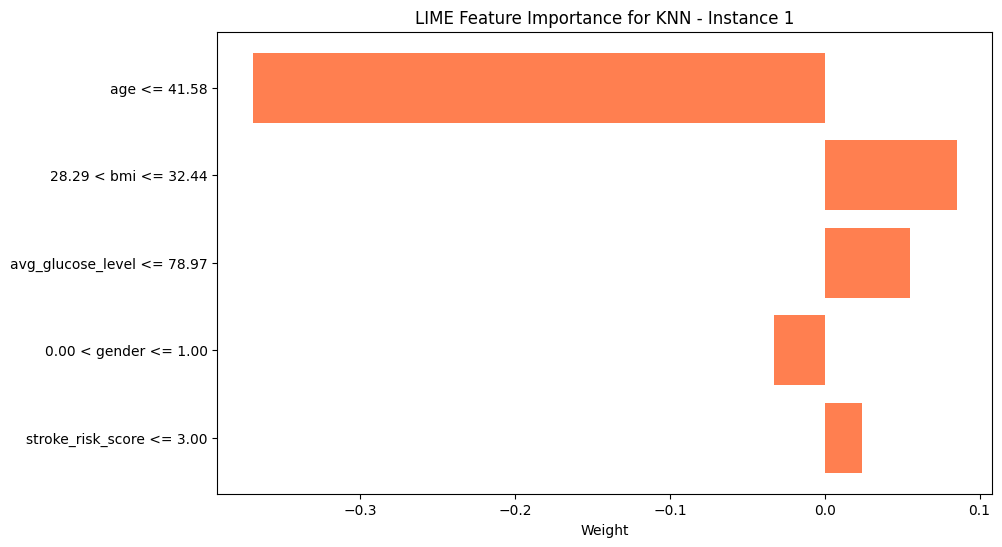

In [8]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_res, y_train_res)
y_pred = knn_model.predict(X_test)

print("KNN Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

explainer_knn = LimeTabularExplainer(
    training_data=X_train_res.values,
    mode='classification',
    feature_names=X.columns,
    class_names=['No Stroke', 'Stroke'],
    discretize_continuous=True
)

# Explain an instance (e.g., the first test sample)
instance_idx_knn = 1  # Example: Second sample in the test set
exp_knn = explainer_knn.explain_instance(X_test.iloc[instance_idx_knn], knn_model.predict_proba, num_features=5)

# Show explanation in notebook
exp_knn.show_in_notebook()

# Extract feature importance
lime_explanation_knn = exp_knn.as_list()
lime_df_knn = pd.DataFrame(lime_explanation_knn, columns=['Feature', 'Weight'])

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.barh(lime_df_knn['Feature'], lime_df_knn['Weight'], color='coral')
plt.xlabel('Weight')
plt.title(f'LIME Feature Importance for KNN - Instance {instance_idx_knn}')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
